# Overview

This iPython notebook demonstrates how we train UNets of varying receptive fields using PyTorch. For more details, please see our paper, "Understanding the Influence of Receptive Field and Network Complexity in Neural-Network-Guided TEM Image Analysis". We will demonstrate our process using the high-resolution TEM images of 5nm Au nanoparticles from Groschner et al. (2021), generated after our preprocessing routine (see other notebook). In our paper, we repeat this process for all datasets.

# Import Packages

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import h5py
import numpy as np
import time
from pandas import DataFrame
import matplotlib.pyplot as plt

# Data and Model Definitions

First, we need to define a new Dataset object that imports the entire dataset and corresponding labels, and then outputs the image/label pair when queried.

In [2]:
#Dataset handling
class TEMImageDataset(Dataset):
  """Creates a Dataset object that takes in a h5 file with all the training images"""

  def __init__(self, image_filepath, img_key, labels_filepath, lbl_key):
    """ Args:
      image_filepath (string): path to the h5 file with the images
      img_key (string): the "key" for the images in the h5 file
      labels_filepath (string): path to the h5 file with the maps/labels
      lbl_key (string): the "key" for the labels in the h5 file
    """
    self.image = h5py.File(image_filepath,'r')[img_key][:,:,:,:]
    self.labels = h5py.File(labels_filepath,'r')[lbl_key][:,:,:,:]
  
  def __len__(self):
    return self.image.shape[0]
  
  def __getitem__(self, idx):
    #If the provided idx is a tensor, then convert it to a list
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    images = self.image[idx] #Note that these output np arrays, not tensors
    labels = self.labels[idx]
    sample = {'image': images, 'label': labels}
    
    return sample

Next, we will build our UNet architecture. As the UNet is constructed of residual blocks, we will first create a module that defines a residual block.

In [3]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size1, kernel_size2):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size1, padding=(kernel_size1-1)//2)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size2, padding=(kernel_size2-1)//2)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.conv_add = nn.Conv2d(in_channels,out_channels,kernel_size = 1) #Expands/contracts input image in the filter dimension for the ReLU skip connection

    #Copied from torchvision to correctly initialize layers
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    skip = self.conv_add(x)
    out += skip
    out = self.relu2(out)
    return out

Finally, we can build the UNet.

In [4]:
class UNet(nn.Module):
  def __init__(self, num_blocks,filter_sequence,max_pool_sequence, num_classes = 2):
    #num_blocks: number of residual blocks in network
    #filter_sequence: list of filter sizes
    #max_pool_sequence: list of max pooling filter sizes
   
    super(UNet, self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
   
    self.pools = nn.ModuleList()
    self.upsamples = nn.ModuleList()
    
    # creates down and pooling layers
    in_channels = 1
    for i in range(num_blocks):
        self.downs.append(ResidualBlock(in_channels,filter_sequence[i],3,3))
        in_channels = filter_sequence[i]
        self.pools.append(nn.MaxPool2d(kernel_size = max_pool_sequence[i], stride = max_pool_sequence[i]))

    # creates up and upsampling layers
    for i in reversed(range(num_blocks)):
        self.ups.append(ResidualBlock(filter_sequence[i]+filter_sequence[i+1],filter_sequence[i],3,3)) #The 2*filters in the input channels refers to the extra channels from the concat layer
        self.upsamples.append(nn.Upsample(scale_factor=max_pool_sequence[i]))

    # "bottleneck" or middle part at bottom of U
    self.bottleneck = ResidualBlock(filter_sequence[num_blocks-1],filter_sequence[num_blocks],3,3)

    # final convolution with 1x1 kernel
    self.final_conv = nn.Conv2d(filter_sequence[0], num_classes, kernel_size = 1)

    self.num_blocks = num_blocks

  
  def forward(self, x):
  
    skips = [] # empty array to store skip connections

    for i in range(self.num_blocks):
        x = self.downs[i](x)
        skips.append(x)
        x = self.pools[i](x)

    x = self.bottleneck(x)
    skips = skips[::-1] # reverse skips array because we want to work with latest one first

    for idx in range(self.num_blocks):
      x = self.upsamples[idx](x)
      skip = skips[idx]
      concat_skip = torch.cat((skip,x),dim=1)
      x = self.ups[idx](concat_skip)

    out = self.final_conv(x)

    return out

# Training and Testing Routines

Here, we will define the training and testing loops, as well as our dice score metrics

In [5]:
#Training definitions
def train_loop(dataloader, model, loss_fn, optimizer, device):
  avg_loss = 0
  dice_score = 0
  hard_dice = 0
  size = len(dataloader.dataset)
  model.train()
  for batch_i, sample_batch in enumerate(dataloader):
    #Move the images and labels to the GPU
    images = sample_batch['image'].to(device)
    labels = sample_batch['label'].type(torch.LongTensor).to(device)

    #Compute the prediction (i.e. forward pass)
    pred = model(images)
    
    #Compute the loss
    loss = loss_fn(pred,labels[:,0,:,:]) #can't have dimensions in the channel index

    #Backpropagation
    #First, reset the gradients of the model parameters
    optimizer.zero_grad()
    #Back prop the prediction loss
    loss.backward()
    #Adjust the parameters using the gradients collected
    optimizer.step()

    #Log the loss and dice score
    avg_loss += loss.item()*sample_batch['image'].shape[0] #Undo the normalization by mini-batch size
    dice_score += compute_dice(pred, labels, device).item()
    hard_dice += compute_dice_hard(pred, labels, device).item()

  #After going through all the batches, compute the average loss and dice score
  return avg_loss/size, dice_score/size, hard_dice/size

In [6]:
def test_loop(dataloader, model, loss_fn, optimizer, device):
  avg_loss = 0
  dice_score = 0
  hard_dice = 0
  size = len(dataloader.dataset)
  model.eval()
  with torch.no_grad():
    for batch_i, sample_batch in enumerate(dataloader):
      #Move the images and labels to the GPU
      images = sample_batch['image'].to(device)
      labels = sample_batch['label'].type(torch.LongTensor).to(device)
      #Compute the prediction (i.e. forward pass)
      pred = model(images)
      #Compute the loss
      loss = loss_fn(pred,labels[:,0,:,:]) 
      #Log the loss and dice score
      avg_loss += loss.item()*sample_batch['image'].shape[0] #Undo the normalization by mini-batch size
      dice_score += compute_dice(pred, labels, device).item()
      hard_dice += compute_dice_hard(pred, labels, device).item()

  #After going through all the batches, compute the average loss and dice score
  return avg_loss/size, dice_score/size, hard_dice/size

In [7]:
def compute_dice(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  sm_layer = nn.Softmax2d()
  y_pred = sm_layer(y_pred) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.sum(torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth))

In [8]:
def compute_dice_hard(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  sm_layer = nn.Softmax2d()
  y_pred = torch.round(sm_layer(y_pred)) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.sum(torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth))

# Determine number of training epochs

First, we need to determine the number of training epochs, or how many times we will run our training loop. We will do so by identifying when the loss function for the training and validation datasets diverge, or in other words, when the model starts to overfit to the training dataset.

We will determine this for a 4-residual block network, which should have the greatest chance of overfitting. 

In [10]:
#Import the data
train_img_filepath = '../dataset_preprocessing/Au_Training_DiAugment_Norm_PyTorch_Images.h5'
train_lbl_filepath = '../dataset_preprocessing/Au_Training_DiAugment_Norm_PyTorch_Labels.h5'
train_dataset = TEMImageDataset(image_filepath=train_img_filepath,img_key='images',labels_filepath=train_lbl_filepath,lbl_key = 'labels')

valid_img_filepath = '../dataset_preprocessing/Au_Validation_DiAugment_Norm_PyTorch_Images.h5'
valid_lbl_filepath = '../dataset_preprocessing/Au_Validation_DiAugment_Norm_PyTorch_Labels.h5'
valid_dataset = TEMImageDataset(image_filepath=valid_img_filepath,img_key='images',labels_filepath=valid_lbl_filepath,lbl_key = 'labels')

Next, we specify the UNet architecture

In [11]:
#Specify model parameters
num_blocks = 4 #Number of residual blocks is 4
filter_sequence = [4,8,16,32,64] #The number of filters will increase with each residual block
pool_sequence = [2,2,2,2] #All max pooling filter sizes are set to 2

We then specify the training parameters. We will train for 400 epochs.

In [12]:
learning_rate = 1e-4
b_size = 32 #Batch size. Since we utilize batch norm layers, it is better to have a larger batch size. However, this will increase the amount of GPU RAM needed.
epochs = 400

Next, we set the randomization seed before we initialize any matricies, or any functions that may be affected by the randomization seed.

In [13]:
seed_num = 9213
torch.manual_seed(seed_num)

Next, we create the DataLoader object which will randomly create batches of images from our training/validation datasets.

In [14]:
#Setup the data loader
train_dataloader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=b_size, shuffle=True, num_workers=4)

Now we can setup our model and move it to our GPU (if available).

In [15]:
model = UNet(num_blocks,filter_sequence,pool_sequence)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

#Setup GPU and move model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

Finally, we can start training. We record the average loss function, dice score, and hard dice score at the end of each epoch for the training and validation datasets. On our GPU, this takes about 10Gb of RAM and runs for around 53 minutes

In [17]:
#Set the logging variables
history = {'loss': [], 'dice_coef': [], 'hard_dice_coef': [], 'val_loss': [], 'val_dice_coef': [], 'val_hard_dice_coef': [], 'time': []}
    
#Run the training
for t in range(epochs):
    start_time=time.time()
    avg_loss, avg_dice, avg_hard_dice = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    history['loss'].append(avg_loss)
    history['dice_coef'].append(avg_dice)
    history['hard_dice_coef'].append(avg_hard_dice)
    val_loss, val_dice, val_hard_dice = test_loop(valid_dataloader, model, loss_fn, optimizer, device)
    history['val_loss'].append(val_loss)
    history['val_dice_coef'].append(val_dice)
    history['val_hard_dice_coef'].append(val_hard_dice)  
    end_time = time.time()
    history['time'].append(end_time-start_time)
    print('Epoch: '+ str(t) + ' Val Dice: '+str(val_dice) + ' Time: '+str(end_time-start_time), end='\r')

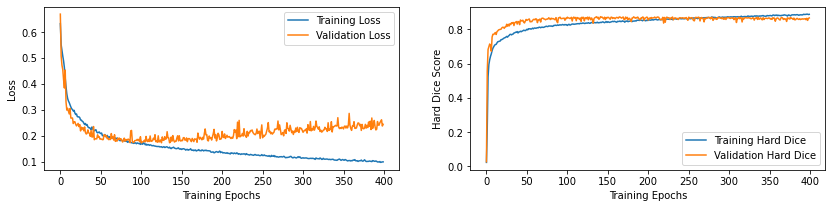

In [20]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history['hard_dice_coef'], label='Training Hard Dice')
plt.plot(history['val_hard_dice_coef'], label='Validation Hard Dice')
plt.xlabel('Training Epochs')
plt.ylabel('Hard Dice Score')
plt.legend()

In the above graph, we see that the loss functions start to diverge around 100 epochs. Therefore, for this dataset, we will train our models for 100 epochs.

# Training Models of Varying Receptive Field

We will now demonstrate how we train models of varying receptive field. Note that the below example is for a single run; in our paper, we repeat this five times to get average performance. 

In [21]:
#Import the data
train_img_filepath = '../dataset_preprocessing/Au_Training_DiAugment_Norm_PyTorch_Images.h5'
train_lbl_filepath = '../dataset_preprocessing/Dataset Creation/Au_Training_DiAugment_Norm_PyTorch_Labels.h5'
train_dataset = TEMImageDataset(image_filepath=train_img_filepath,img_key='images',labels_filepath=train_lbl_filepath,lbl_key = 'labels')

valid_img_filepath = '../dataset_preprocessing/Dataset Creation/Au_Validation_DiAugment_Norm_PyTorch_Images.h5'
valid_lbl_filepath = '../dataset_preprocessing/Dataset Creation/Au_Validation_DiAugment_Norm_PyTorch_Labels.h5'
valid_dataset = TEMImageDataset(image_filepath=valid_img_filepath,img_key='images',labels_filepath=valid_lbl_filepath,lbl_key = 'labels')

We again set our model parameters. Here, we will be examining performance for a 2-residual-block UNet.

In [24]:
pool_sequences = [[2,2],[2,4],[2,8],[4,2],[4,4],[4,8],[8,2],[8,4],[8,8]] #List of different max pooling configurations

#Specify training parameters
learning_rate = 1e-4
b_size = 32
epochs = 100

#Specify model parameters
num_blocks = 2
filter_sequence = [4,8,16]

We can then run our for-loop which trains a different max pooling configuration every pass through. On our workstation, this runs for around 93 minutes.

In [25]:
for i in pool_sequences:
    ps_string = str(i[0])+str(i[1])
    
    #Globally setting the random seed
    seed_num = 752
    torch.manual_seed(seed_num)
    
    #Setup the data loader
    train_dataloader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, num_workers=4)
    valid_dataloader = DataLoader(valid_dataset, batch_size=b_size, shuffle=True, num_workers=4)

    model = UNet(num_blocks,filter_sequence,i)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

    #Setup GPU and move model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #Set the logging variables
    history = {'loss': [], 'dice_coef': [], 'hard_dice_coef': [], 'val_loss': [], 'val_dice_coef': [], 'val_hard_dice_coef': [], 'time': []}
    
    #Run the training
    for t in range(epochs):
      start_time=time.time()
      avg_loss, avg_dice, avg_hard_dice = train_loop(train_dataloader, model, loss_fn, optimizer, device)
      history['loss'].append(avg_loss)
      history['dice_coef'].append(avg_dice)
      history['hard_dice_coef'].append(avg_hard_dice)
      val_loss, val_dice, val_hard_dice = test_loop(valid_dataloader, model, loss_fn, optimizer, device)
      history['val_loss'].append(val_loss)
      history['val_dice_coef'].append(val_dice)
      history['val_hard_dice_coef'].append(val_hard_dice)  
      end_time = time.time()
      history['time'].append(end_time-start_time)
      print('Max Pool '+ps_string+' Epoch: '+ str(t) + ' Val Dice: '+str(val_dice) + ' Time: '+str(end_time-start_time), end='\r')
  

    #Save model and history file
    torch.save(model, 'UNet_b2_Au_m'+ps_string+'_run1_model.h5')
    history_dataframe = DataFrame(history)
    hist_filename = 'UNet_b2_Au_m'+ps_string+'_run1_trainingLossHistory.csv'
    with open(hist_filename, mode='w') as f:
      history_dataframe.to_csv(f)

We then evaluate the models' performance on the test set.

In [26]:
# Load the test set
img_filepath = '../dataset_preprocessing/Au_Test_DiAugment_Norm_PyTorch_Images.h5'
lbl_filepath = '../dataset_preprocessing/Au_Test_DiAugment_Norm_PyTorch_Labels.h5'
test_dataset = TEMImageDataset(image_filepath=img_filepath,img_key='images',labels_filepath=lbl_filepath,lbl_key = 'labels')

In [27]:
# Set the test dataloader parameters
learning_rate = 1e-4
b_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True, num_workers=0)

In [30]:
# Get the test results
test_results = {'mp': [], 'run': [], 't_loss': [], 't_dice': [], 't_hard_dice': []}
trained_models_folder = ''
pool_seq = [[2,2],[2,4],[2,8],[4,2],[4,4],[4,8],[8,2],[8,4],[8,8]]
num_blocks = 2
filter_sequence = [4,8,16,32,64,128,256]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i in pool_seq:
    runs = [1]
    for r in runs:
        pool_str = str(i[0])+str(i[1])
        model_path = 'UNet_b2_Au_m'+pool_str+'_run'+str(r)+'_model.h5'
        model = UNet(num_blocks, filter_sequence, i)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
        
        model = torch.load(trained_models_folder+model_path)
        model.to(device)
        
        test_loss, test_dice, test_hard_dice = test_loop(test_dataloader, model, loss_fn, optimizer, device)
        test_results['mp'].append(pool_str)
        test_results['run'].append(r)
        test_results['t_loss'].append(test_loss)
        test_results['t_dice'].append(test_dice)
        test_results['t_hard_dice'].append(test_hard_dice)

history_dataframe = DataFrame(test_results)
hist_filename = trained_models_folder+'test_results.csv'
with open(hist_filename, mode='w') as f:
    history_dataframe.to_csv(f)

We have already calculated the receptive fields (in pixels and nanometers) for this architecture and dataset, and so we can plot out how performance changes on this single run

Text(0, 0.5, 'Test Hard Dice Score')

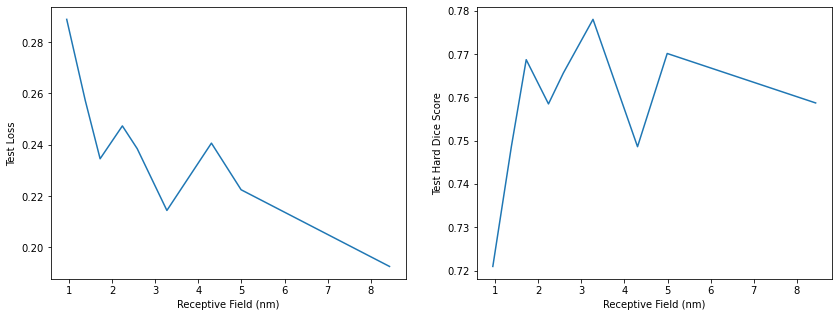

In [32]:
# Receptive field in pixels
rf = np.asarray([44, 64, 80, 104, 120, 152, 200, 232, 392])
# Multiply the receptive field by pixel scale (nm/pixel)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(rf*0.02152,test_results['t_loss'])
plt.xlabel('Receptive Field (nm)')
plt.ylabel('Test Loss')
plt.subplot(1,2,2)
plt.plot(rf*0.02152,test_results['t_hard_dice'])
plt.xlabel('Receptive Field (nm)')
plt.ylabel('Test Hard Dice Score')

Above, we can see how segmentation performance increases with receptive field and then plateaus a bit. With the loss function, lower is better while for the hard dice score, higher is better. To get a better idea as to the trend, we need to repeat this for multiple runs to get average performance.